In [92]:
import os
import fire
import csv
import json
import math
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np

# wdir = '../results/hpsearch-2022-01-02/'
wdir = '../results/hpsearch-2022-01-11/'
# wdir = '../results/hpsearch-2022-01-13/'

In [93]:
runs_json_fname='runs.json'

runs_json = os.path.join(wdir, runs_json_fname)
hpconfig_json = os.path.join(wdir, 'hpsearch_config.json')
results_tsv = os.path.join(wdir, 'results.tsv')

runs = {}
with open(runs_json) as f:
  for line in f:
    run = json.loads(line)
    runs[run['run_id']] = run

results = []
with open(results_tsv) as f:
  for row in csv.DictReader(f, delimiter='\t'):
    for k in row.keys():
      if k.startswith('max_'):
        row[k] = float(row[k])
      elif k == 'run_id':
        row[k] = int(row[k])
    row['params'] = runs[row['run_id']]
    results.append(row)
del runs
print('Found {} results'.format(len(results)))

result_keys = [rkey for rkey in results[0].keys() if rkey.startswith('max_')]

with open(hpconfig_json) as f:
  hpconfig = json.load(f)


Found 54 results


In [89]:
param_names = {
 'STDP-RL:AMPA:RLlenhebb': 'AMPA-RLlenhebb',
 'STDP-RL:AMPA:RLhebbwt': 'AMPA-RLhebbwt',
 'STDP-RL:AMPA:RLwindhebb': 'AMPA-RLwindhebb',
 'sim:targetedRL': 'Targeted_RL_Type',
 'sim:targetedNonEM': 'Non_Motor_RL',
 'sim:targetedRLMainFctr': 'Targeted_RL_Main_EM',
 'sim:targetedRLOppFctr': 'Targeted_RL_Opp_EM',
 'sim:targetedRLDscntFctr': 'Targeted_RL_Non_Motor',
 'critic:posRewardBias': 'Critic Positivity Bias',
 'critic:angv_bias': 'Critic Angv Bias',
 'critic:total_gain': 'Critic Total Gain',
 'net:deactivateNMDA': 'Deactivate NMDA',
 'simtype:ResumeSimFromFile': 'Initialization model',
}

vals_names = {
 'sim:targetedRL': {1: 'Non-Targeted', 2: 'Targeted-Main', 3: 'Targeted-Both'},
 'sim:targetedNonEM': {0: 'False', 1: 'True'},
}


In [69]:
### For 2022-01-02 (first HP Search)
param_keys = [
 'STDP-RL:AMPA:RLlenhebb',
 'STDP-RL:AMPA:RLhebbwt',
 'STDP-RL:AMPA:RLwindhebb',
 'sim:targetedRL',
 'sim:targetedRLOppFctr',
 'sim:targetedNonEM',
 'critic:posRewardBias',
 'critic:angv_bias']

# param_keys = list(hpconfig['params'].keys())

In [94]:
### For 2022-01-11 (second HP Search)
param_keys = [
 'simtype:ResumeSimFromFile',
 'STDP-RL:AMPA:RLhebbwt',
 'STDP-RL:AMPA:RLwindhebb',
 'sim:targetedNonEM',
 'sim:targetedRLOppFctr',
 'sim:targetedRLDscntFctr',
 'critic:posRewardBias',
 'critic:angv_bias',
]


In [90]:
### For 2022-01-13 (third HP Search)
param_keys = [
 'simtype:ResumeSimFromFile',
 'STDP-RL:AMPA:RLhebbwt',
 'sim:targetedNonEM',
 'sim:targetedRLOppFctr',
 'sim:targetedRLDscntFctr',
 'critic:posRewardBias',
 'critic:angv_bias',
]


Initialization model  p:  0.00012509583169645097   maxvar/minvar=  1.6401311019738336
AMPA-RLhebbwt  p:  1.241031370506251e-05   maxvar/minvar=  2.0120901507966424
AMPA-RLwindhebb  p:  0.027380963096561645   maxvar/minvar=  1.8124251836515928
Non_Motor_RL  p:  0.6395039794986126   maxvar/minvar=  1.2210606105333435
Targeted_RL_Opp_EM  p:  0.4389450073609453   maxvar/minvar=  1.9713218786736875
Targeted_RL_Non_Motor  p:  0.2510387329597287   maxvar/minvar=  1.3401820301462324
Critic Positivity Bias  p:  0.632764760166286   maxvar/minvar=  1.3479748593339809
Critic Angv Bias  p:  0.04304635496151517   maxvar/minvar=  1.7227679172137653


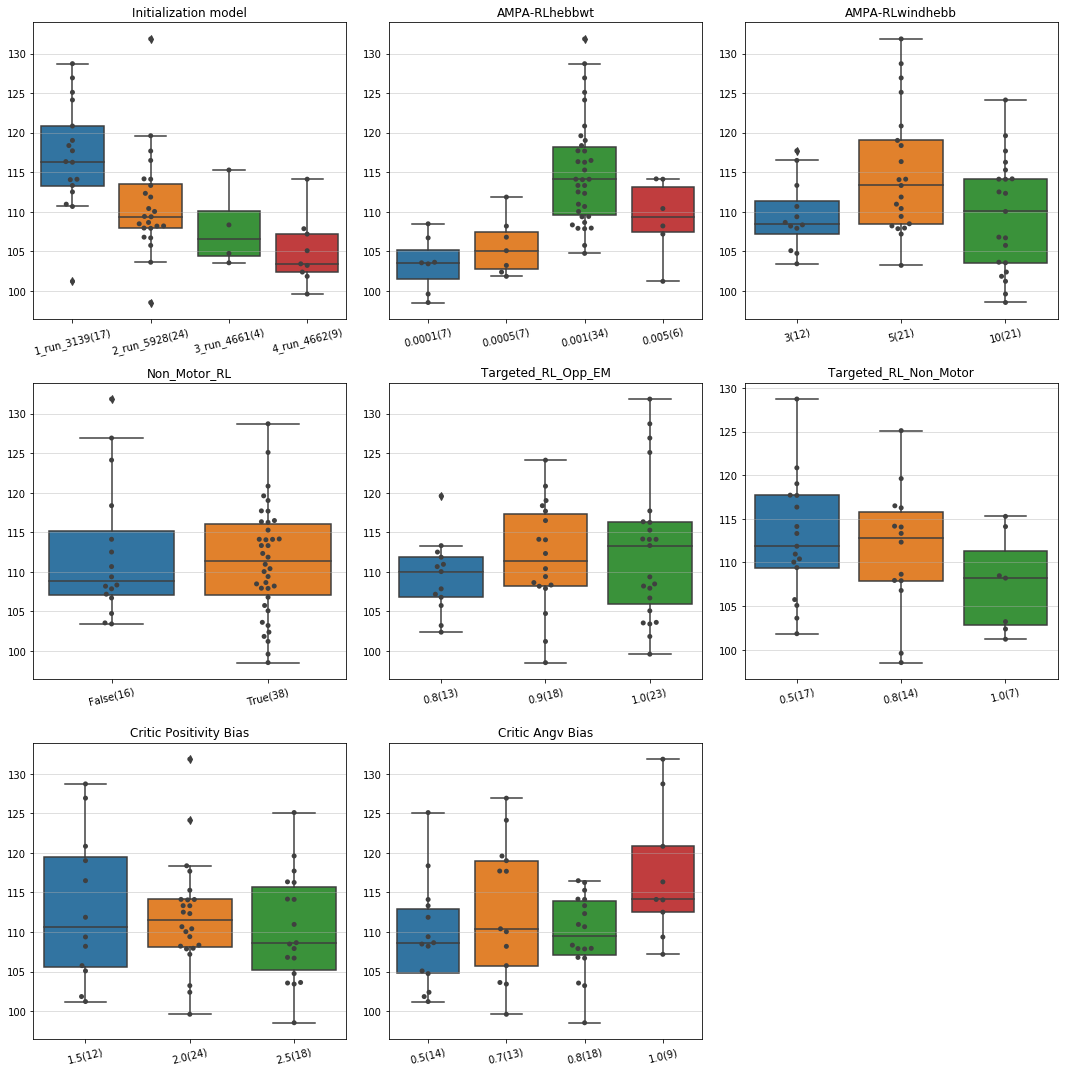

In [95]:
import seaborn as sns

ncols = 3
figsize = 15

# for result_key in result_keys:
result_key = 'max_average_s100'
    
nrows = math.ceil(len(param_keys) / ncols)
if nrows == 1:
  ncols = len(conns)
fig, axs = plt.subplots(
  ncols=ncols, nrows=nrows,
  figsize=(figsize, figsize))
# fig.suptitle('HyperParam Search Results ({} Episodes) during training'.format(
#   result_key.replace('_s', '_over_').replace('_', ' ')))

param_idx = 0
for axi in axs:
  if nrows == 1:
    axi = [axi]
  for ax in axi:
    if param_idx == len(param_keys):
      ax.axis('off')
      continue

    key = param_keys[param_idx]
    param_name = param_names[key]
    vals = dict([(v, []) for v in hpconfig['params'][key]])
    for res in results:
      param_key = res['params'][key]
      if type(param_key) == str and 'synWeights_final.pkl' in param_key:
        new_param_key = param_key.split('/')[-2]
        if new_param_key not in vals:
          del vals[param_key]
          vals[new_param_key] = []
        param_key = new_param_key
      if key == 'sim:targetedRLOppFctr' and 'sim:targetedRL' in res['params'] and res['params']['sim:targetedRL'] != 3:
        continue
      if key == 'sim:targetedRLDscntFctr' and 'sim:targetedNonEM' in res['params'] and res['params']['sim:targetedNonEM'] != 1:
        continue
      vals[param_key].append(res[result_key])

    valkeys = sorted(list(vals.keys()))
    data = [vals[vk] for vk in valkeys]
    # compute stats
    F, p = stats.f_oneway(*data)
    stds = [np.std(data[i]) for i in range(len(data))]
    print(param_name, ' p: ', p, '  maxvar/minvar= ', max(stds) / min(stds))
    # plot
    ax = sns.boxplot(data=data, ax=ax)
    ax = sns.swarmplot(data=data, color=".25", ax=ax)
    ax.set_xticklabels(
      ['{}({})'.format(vals_names[key][vk] if key in vals_names else vk, len(vals[vk])) for vk in valkeys],
      rotation=14)
#     ax.set_ylabel(result_key)
    ax.set_title(param_name)
    ax.grid(axis='y', alpha=0.5)

    param_idx += 1

outputfile = os.path.join(wdir, 'eval_params_new_{}.png'.format(result_key))
plt.tight_layout()
plt.savefig(outputfile, dpi=150)

In [76]:
res['params']

{'run_id': 4309,
 'STDP-RL:AMPA:RLlenhebb': 200,
 'STDP-RL:AMPA:RLlenanti': 200,
 'STDP-RL:AMPA:RLhebbwt': 0.005,
 'STDP-RL:AMPA:RLantiwt': -0.005,
 'STDP-RL:AMPA:RLwindhebb': 25,
 'STDP-RL:AMPA:RLwindanti': 25,
 'sim:targetedRL': 3,
 'sim:targetedRLOppFctr': 1.0,
 'sim:targetedNonEM': 1,
 'critic:posRewardBias': 1.5,
 'critic:angv_bias': 0.5}

### Test normality assumption for running ANOVA

In [71]:
tested_param_key = 'sim:targetedRLOppFctr'

hpconfig['params']

{'STDP-RL:AMPA:RLlenhebb': [50, 100, 200, 250, 400],
 'STDP-RL:AMPA:RLlenanti': [50, 100, 200, 250, 400],
 'STDP-RL:AMPA:RLhebbwt': [0.02, 0.01, 0.005],
 'STDP-RL:AMPA:RLantiwt': [-0.02, -0.01, -0.005],
 'STDP-RL:AMPA:RLwindhebb': [2, 3, 5, 10, 25],
 'STDP-RL:AMPA:RLwindanti': [2, 3, 5, 10, 25],
 'sim:targetedRL': [1, 2, 3],
 'sim:targetedRLOppFctr': [0.8, 1.0],
 'sim:targetedNonEM': [0, 1],
 'critic:posRewardBias': [1.5, 2.5, 2.8],
 'critic:angv_bias': [0.4, 0.5, 0.7, 1.0]}

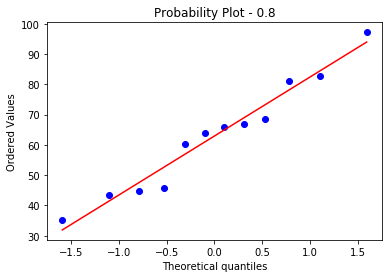

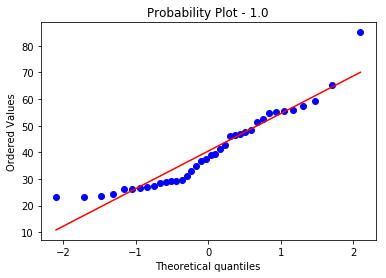

In [72]:
vals = dict([(v, []) for v in hpconfig['params'][tested_param_key]])
for res in results:
    param_key = res['params'][tested_param_key]
    vals[param_key].append(res[result_key])
valkeys = sorted(list(vals.keys()))
data = [vals[vk] for vk in valkeys]

for key, data in vals.items():
    stats.probplot(data, plot=plt)
    plt.title("Probability Plot - " + str(key))
    plt.show()